In [1]:
#Imports 

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForQuestionAnswering, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Dataset Class

class QADataset(Dataset):  
    def __init__(self, encoded_data):  
        self.input_ids = torch.tensor(encoded_data['input_ids'])
        self.token_type_ids = torch.tensor(encoded_data['token_type_ids'])
        self.attention_mask = torch.tensor(encoded_data['attention_mask'])
        self.start_positions = torch.tensor(encoded_data['start_positions'])
        self.end_positions = torch.tensor(encoded_data['end_positions'])
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'start_positions': self.start_positions[idx],
            'end_positions': self.end_positions[idx]
        }
    
    def __len__(self):
        return len(self.input_ids)

In [3]:
# Functions to calculate F1 score and Exact Match Score

def clean_text(text): 
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def calculate_exact_match(pred_text, ref_text):  # Changed from compute_exact_match
    return float(clean_text(pred_text) == clean_text(ref_text))

def calculate_f1_score(pred_text, ref_text):  # Changed from compute_f1
    pred_tokens = clean_text(pred_text).split()
    ref_tokens = clean_text(ref_text).split()
    
    if len(pred_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0
    
    common = Counter(pred_tokens) & Counter(ref_tokens)
    num_same = sum(common.values())
    
    if num_same == 0:
        return 0.0
        
    precision = num_same / len(pred_tokens)
    recall = num_same / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    f1 = 2.0 * precision * recall / (precision + recall)
    return f1

In [4]:
# Helper functions to read the json files, to fetch the data

def load_qa_data(file_path):  
    with open(file_path, 'rb') as f:
        raw_data = json.load(f)
    
    contexts, questions, answers = [], [], []
    for group in raw_data['data']:
        for para in group['paragraphs']:
            context = para['context'].lower()
            for qa in para['qas']:
                question = qa['question'].lower()
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answer['text'] = answer['text'].lower()
                    answers.append(answer)
    return contexts, questions, answers

def update_answer_boundaries(answers, contexts): 
    for answer, context in zip(answers, contexts):
        answer_text = answer['text']
        start_pos = answer['answer_start']
        end_pos = start_pos + len(answer_text)

        if context[start_pos:end_pos] == answer_text:
            answer['answer_end'] = end_pos
        else:
            for offset in [1, 2]:
                if context[start_pos - offset:end_pos - offset] == answer_text:
                    answer['answer_start'] = start_pos - offset
                    answer['answer_end'] = end_pos - offset
                    break

In [5]:
# Helper function which helps in tokenization

def locate_answer_spans(encoded_data, answers, tokenizer, max_length):
    start_spans = []
    end_spans = []

    for idx in range(len(encoded_data['input_ids'])):
        answer_text = answers[idx]['text']
        answer_tokens = tokenizer(answer_text, max_length=max_length, truncation=True, padding=True)

        span_found = False
        for pos in range(len(encoded_data['input_ids'][idx]) - len(answer_tokens['input_ids'])):
            is_match = True
            for i in range(1, len(answer_tokens['input_ids'])-1):
                if answer_tokens['input_ids'][i] != encoded_data['input_ids'][idx][pos + i]:
                    is_match = False
                    break
            if is_match:
                start_spans.append(pos)
                end_spans.append(pos + len(answer_tokens['input_ids']) - 1)
                span_found = True
                break
        if not span_found:
            start_spans.append(0)
            end_spans.append(0)

    return start_spans, end_spans

In [6]:
# Function used to train the model

def train_qa_model(model, data_loader, device, num_epochs):  
    model.to(device)
    model.train()
    
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
    total_steps = num_epochs * len(data_loader)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )
    
    metrics = {'loss': [], 'accuracy': []}  # Changed from history
    
    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracies = []
        with tqdm(data_loader, desc=f'Epoch {epoch+1}') as progress_bar:
            for batch in progress_bar:
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask,
                              start_positions=start_positions,
                              token_type_ids=token_type_ids,
                              end_positions=end_positions)
                
                loss = outputs[0]
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                start_logits, end_logits = outputs[1], outputs[2]
                start_pred = start_logits.argmax(dim=1)
                end_pred = end_logits.argmax(dim=1)
                batch_accuracy = ((start_pred == start_positions).float().mean() + 
                                (end_pred == end_positions).float().mean()) / 2
                
                epoch_losses.append(loss.item())
                epoch_accuracies.append(batch_accuracy.item())
                
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'accuracy': f'{batch_accuracy.item():.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })
        
        avg_loss = np.mean(epoch_losses)
        avg_accuracy = np.mean(epoch_accuracies)
        metrics['loss'].append(avg_loss)
        metrics['accuracy'].append(avg_accuracy)
        
        print(f'Epoch {epoch + 1} - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}')
    
    return metrics

In [7]:
# Evaluating the model

def evaluate_qa_model(model, eval_loader, tokenizer, device): 
    model.eval()
    all_predictions = []
    all_references = []
    top_n = 20  
    max_span_length = 30  
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          start_positions=start_positions,
                          end_positions=end_positions)

            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            
            for i in range(len(input_ids)):
                start_pred = torch.argmax(start_logits[i]).item()
                end_pred = torch.argmax(end_logits[i]).item()
                
                # Skip invalid predictions
                if start_pred > end_pred or end_pred - start_pred + 1 > max_span_length:
                    predicted_text = ""
                else:
                    predicted_text = tokenizer.decode(
                        input_ids[i][start_pred:end_pred + 1],
                        skip_special_tokens=True
                    )
                
                ref_start = batch['start_positions'][i].item()
                ref_end = batch['end_positions'][i].item()
                reference_text = tokenizer.decode(
                    input_ids[i][ref_start:ref_end + 1],
                    skip_special_tokens=True
                )
                
                all_predictions.append(predicted_text)
                all_references.append(reference_text)
    

    f1_scores = []
    exact_match_scores = [] 
    
    for pred, ref in zip(all_predictions, all_references):
        if not pred.strip() or not ref.strip():
            f1_scores.append(0.0)
            exact_match_scores.append(0.0)
            continue
        
        f1_scores.append(calculate_f1_score(pred, ref))
        exact_match_scores.append(calculate_exact_match(pred, ref))
    
    return {
        'f1': np.mean(f1_scores) * 100,
        'exact_match': np.mean(exact_match_scores) * 100
    }

In [8]:
def plot_training_metrics(metrics): 
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['accuracy'])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_metrics_bert_docstride.png')
    plt.show()
    plt.close()

Using device: cuda


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading training data...
Starting training...


Epoch 1: 100%|██████████| 2320/2320 [17:39<00:00,  2.19it/s, loss=2.2125, accuracy=0.4286, lr=1.50e-05]


Epoch 1 - Avg Loss: 1.9910, Avg Accuracy: 0.4807


Epoch 2: 100%|██████████| 2320/2320 [17:39<00:00,  2.19it/s, loss=1.3878, accuracy=0.5000, lr=1.00e-05]


Epoch 2 - Avg Loss: 1.1431, Avg Accuracy: 0.6639


Epoch 3: 100%|██████████| 2320/2320 [17:39<00:00,  2.19it/s, loss=0.7428, accuracy=0.7143, lr=5.00e-06]


Epoch 3 - Avg Loss: 0.7982, Avg Accuracy: 0.7454


Epoch 4: 100%|██████████| 2320/2320 [17:39<00:00,  2.19it/s, loss=0.3761, accuracy=0.9286, lr=0.00e+00]


Epoch 4 - Avg Loss: 0.6018, Avg Accuracy: 0.7999


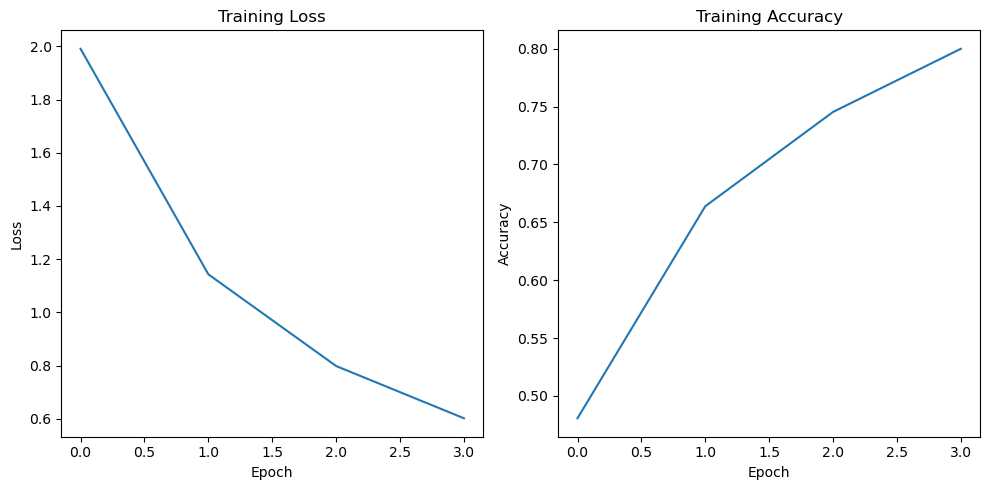


Evaluating on No Noise test set...


Evaluating: 100%|██████████| 993/993 [02:32<00:00,  6.50it/s]


Results for No Noise:
F1 Score: 69.39%
EM Score: 48.42%

Evaluating on WER 44 test set...


Evaluating: 100%|██████████| 1116/1116 [02:51<00:00,  6.50it/s]


Results for WER 44:
F1 Score: 38.04%
EM Score: 26.53%

Evaluating on WER 54 test set...


Evaluating: 100%|██████████| 1116/1116 [02:51<00:00,  6.50it/s]


Results for WER 54:
F1 Score: 26.25%
EM Score: 18.31%


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration parameters
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LENGTH = 512
doc_stride = 128   # Key parameter for sliding window
BATCH_SIZE = 16
NUM_EPOCHS = 4

# Initialize model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertForQuestionAnswering.from_pretrained(MODEL_NAME)

# Load and preprocess training data
print("Loading training data...")
contexts, questions, answers = load_qa_data('spoken_train-v1.1.json')
update_answer_boundaries(answers, contexts)

# Process training data with doc_stride
train_encoded = tokenizer(
    questions,
    contexts,
    max_length=MAX_SEQ_LENGTH,
    truncation=True,
    padding=True,
    stride=doc_stride,  # Implementing sliding window with doc_stride
    return_offsets_mapping=True,
    return_token_type_ids=True
)

# Locate answer positions
start_positions, end_positions = locate_answer_spans(
    train_encoded, answers, tokenizer, MAX_SEQ_LENGTH
)
train_encoded['start_positions'] = start_positions
train_encoded['end_positions'] = end_positions

# Create dataset and dataloader
train_dataset = QADataset(train_encoded)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train model
print("Starting training...")
training_metrics = train_qa_model(model, train_loader, device, NUM_EPOCHS)
plot_training_metrics(training_metrics)

# Evaluation sets
test_sets = [
    ('No Noise', 'spoken_test-v1.1.json'),
    ('WER 44', 'spoken_test-v1.1_WER44.json'),
    ('WER 54', 'spoken_test-v1.1_WER54.json')
]

# Evaluate on test sets
with open('qa_evaluation_results_bert_docstride.txt', 'w') as f:
    f.write("BERT Question Answering Evaluation Results\n")
    f.write("========================================\n\n")
    
    for dataset_name, test_file in test_sets:
        print(f"\nEvaluating on {dataset_name} test set...")
        test_contexts, test_questions, test_answers = load_qa_data(test_file)
        update_answer_boundaries(test_answers, test_contexts)
        
        # Process test data with doc_stride
        test_encoded = tokenizer(
            test_questions,
            test_contexts,
            max_length=MAX_SEQ_LENGTH,
            truncation=True,
            padding=True,
            stride=doc_stride,  # Using same doc_stride for test data
            return_offsets_mapping=True,
            return_token_type_ids=True
        )
        
        test_start_positions, test_end_positions = locate_answer_spans(
            test_encoded, test_answers, tokenizer, MAX_SEQ_LENGTH
        )
        test_encoded['start_positions'] = test_start_positions
        test_encoded['end_positions'] = test_end_positions
        
        test_dataset = QADataset(test_encoded)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
        
        results = evaluate_qa_model(model, test_loader, tokenizer, device)
        
        print(f"Results for {dataset_name}:")
        print(f"F1 Score: {results['f1']:.2f}%")
        print(f"EM Score: {results['exact_match']:.2f}%")
        
        f.write(f"Results for {dataset_name}:\n")
        f.write(f"F1 Score: {results['f1']:.2f}%\n")
        f.write(f"EM Score: {results['exact_match']:.2f}%\n\n")
    
    f.write("========================================\n")
    f.write("Evaluation completed successfully.\n")